In [ ]:
import os
from glob import glob
import logging
import json
import re

In [ ]:
!pip install earthpy
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
import seaborn as sns
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

__SETUP & CONFIGURATION__

In [ ]:
sns.set_style('white')
sns.set(font_scale=1.5)

logging.basicConfig(
    filename='landsat_processing.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logging.info("Starting Enhanced Landsat processing script")

data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','data'))

Extracted output to /root/earth-analytics/data/cold-springs-fire/.


__CUSTOM IMAGE PROCESSING FUNCTIONS__

In [ ]:
def normalize_array(array, min_val=None, max_val=None):
    """Normalize array to 0-1 range"""
    if min_val is None:
        min_val = np.nanmin(array)
    if max_val is None:
        max_val = np.nanmax(array)

    normalized = (array - min_val) / (max_val - min_val + 1e-8)
    return np.clip(normalized, 0, 1)

def apply_threshold(array, threshold_value, above=True):
    """Create binary mask based on threshold"""
    if above:
        mask = array > threshold_value
    else:
        mask = array < threshold_value
    return mask.astype(float)

def apply_histogram_equalization(array):
    """Enhance contrast using histogram equalization"""
    flat_array = array.flatten()
    valid_vals = flat_array[~np.isnan(flat_array)]

    hist, bin_edges = np.histogram(valid_vals, bins=256)

    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]

    bin_indices = np.digitize(valid_vals, bin_edges[:-1]) - 1
    equalized_vals = cdf[np.clip(bin_indices, 0, len(cdf)-1)]

    result = np.full_like(array, np.nan)
    result[~np.isnan(array)] = equalized_vals

    return result

def apply_gaussian_blur(array, kernel_size=5, sigma=1.0):
    """Apply Gaussian blur using custom kernel"""
    if kernel_size % 2 == 0:
        kernel_size += 1

    x = np.linspace(-sigma, sigma, kernel_size)
    kernel_1d = np.exp(-0.5 * (x / sigma) ** 2)
    kernel_1d = kernel_1d / kernel_1d.sum()

    h, w = array.shape
    blurred = np.zeros_like(array)
    pad = kernel_size // 2

    padded = np.full((h + 2*pad, w + 2*pad), np.nan)
    padded[pad:-pad, pad:-pad] = array

    for i in range(h):
        for j in range(w):
            window = padded[i:i+kernel_size, j+pad]
            valid = window[~np.isnan(window)]
            if len(valid) > 0:
                blurred[i, j] = np.sum(valid * kernel_1d[:len(valid)])

    return blurred

def apply_edge_detection(array):
    """Detect edges using Sobel-like operator"""
    h, w = array.shape
    edges = np.zeros_like(array)

    # Sobel kernels
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    for i in range(1, h-1):
        for j in range(1, w-1):
            window = array[i-1:i+2, j-1:j+2]

            if np.isnan(window).any():
                edges[i, j] = np.nan
                continue

            gx = np.sum(window * sobel_x)
            gy = np.sum(window * sobel_y)

            edges[i, j] = np.sqrt(gx**2 + gy**2)

    return edges

def apply_median_filter(array, window_size=3):
    """Apply median filter to reduce noise"""
    h, w = array.shape
    filtered = np.zeros_like(array)
    pad = window_size // 2

    for i in range(h):
        for j in range(w):
            i_min = max(0, i - pad)
            i_max = min(h, i + pad + 1)
            j_min = max(0, j - pad)
            j_max = min(w, j + pad + 1)

            window = array[i_min:i_max, j_min:j_max]
            valid = window[~np.isnan(window)]

            if len(valid) > 0:
                filtered[i, j] = np.median(valid)
            else:
                filtered[i, j] = np.nan

    return filtered

def create_histogram(array, bins=256):
    """Create histogram of array values"""
    flat_array = array.flatten()
    valid_vals = flat_array[~np.isnan(flat_array)]

    hist, bin_edges = np.histogram(valid_vals, bins=bins)

    return hist, bin_edges

def calculate_contrast_stretch(array, percentile_min=2, percentile_max=98):
    """Apply contrast stretching to enhance visibility"""
    flat_array = array.flatten()
    valid_vals = flat_array[~np.isnan(flat_array)]

    p_min = np.percentile(valid_vals, percentile_min)
    p_max = np.percentile(valid_vals, percentile_max)

    stretched = (array - p_min) / (p_max - p_min)
    stretched = np.clip(stretched, 0, 1)

    return stretched

def apply_morphological_operation(mask, operation='dilate', iterations=1, kernel_size=3):
    """Apply morphological operations (dilate/erode) to binary masks"""
    result = mask.copy()

    for _ in range(iterations):
        new_result = result.copy()
        h, w = result.shape
        pad = kernel_size // 2

        for i in range(pad, h-pad):
            for j in range(pad, w-pad):
                window = result[i-pad:i+pad+1, j-pad:j+pad+1]

                if operation == 'dilate':
                    new_result[i, j] = np.nanmax(window)
                elif operation == 'erode':
                    new_result[i, j] = np.nanmin(window)

        result = new_result

    return result

def blend_images(img1, img2, alpha=0.5):
    """Blend two images together"""
    result = img1 * alpha + img2 * (1 - alpha)
    return result

def calculate_texture_variance(array, window_size=5):
    """Calculate local texture variance"""
    h, w = array.shape
    texture = np.zeros_like(array)
    pad = window_size // 2

    for i in range(pad, h-pad):
        for j in range(pad, w-pad):
            window = array[i-pad:i+pad+1, j-pad:j+pad+1]
            valid = window[~np.isnan(window)]

            if len(valid) > 1:
                texture[i, j] = np.var(valid)
            else:
                texture[i, j] = np.nan

    return texture

def apply_statistical_filter(array, window_size=3, operation='mean'):
    """Apply statistical filters (mean, min, max, std)"""
    h, w = array.shape
    result = np.zeros_like(array)
    pad = window_size // 2

    for i in range(h):
        for j in range(w):
            i_min = max(0, i - pad)
            i_max = min(h, i + pad + 1)
            j_min = max(0, j - pad)
            j_max = min(w, j + pad + 1)

            window = array[i_min:i_max, j_min:j_max]
            valid = window[~np.isnan(window)]

            if len(valid) > 0:
                if operation == 'mean':
                    result[i, j] = np.mean(valid)
                elif operation == 'min':
                    result[i, j] = np.min(valid)
                elif operation == 'max':
                    result[i, j] = np.max(valid)
                elif operation == 'std':
                    result[i, j] = np.std(valid)
            else:
                result[i, j] = np.nan

    return result


__UTILITY FUNCTIONS__

In [ ]:
def open_clean_band(band_path, crop_layer=None):
    """Open and optionally crop a raster band"""
    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path, masked=True).rio.clip(clip_bound, from_disk=True)
        except Exception as err:
            logging.error(f"Clipping error: {err}")
            print("Oops, I need a geodataframe object for this to work")
            print(err)
    else:
        cleaned_band = rxr.open_rasterio(band_path, masked=True).squeeze()
    return cleaned_band

def process_bands(paths, crop_layer=None, stack=False):
    """Process multiple bands with error handling"""
    all_bands = []
    for i, aband in enumerate(paths):
        try:
            cleaned = open_clean_band(aband, crop_layer)
            if 'band' in cleaned.dims and cleaned.sizes['band'] == 1:
                cleaned = cleaned.squeeze('band')
            match = re.search(r'band(\d+)', os.path.basename(aband))
            if match:
                band_num = int(match.group(1))
                cleaned["band"] = band_num
            else:
                logging.warning(f"Could not parse band number from {os.path.basename(aband)}. Using sequential index {i+1}.")
                cleaned["band"] = i + 1
            all_bands.append(cleaned)
            logging.info(f"Successfully processed band {cleaned['band'].values}")
        except Exception as e:
            logging.warning(f"Error processing band {i+1}: {e}")
            continue

    if stack:
        print("Stacking bands")
        stacked_bands = xr.concat(all_bands, dim="band")
        return stacked_bands
    else:
        print(f"Returning {len(all_bands)} bands")
        return all_bands


__ORIGINAL WORKFLOW: LOAD & CLOUD MASK__

Stacking bands


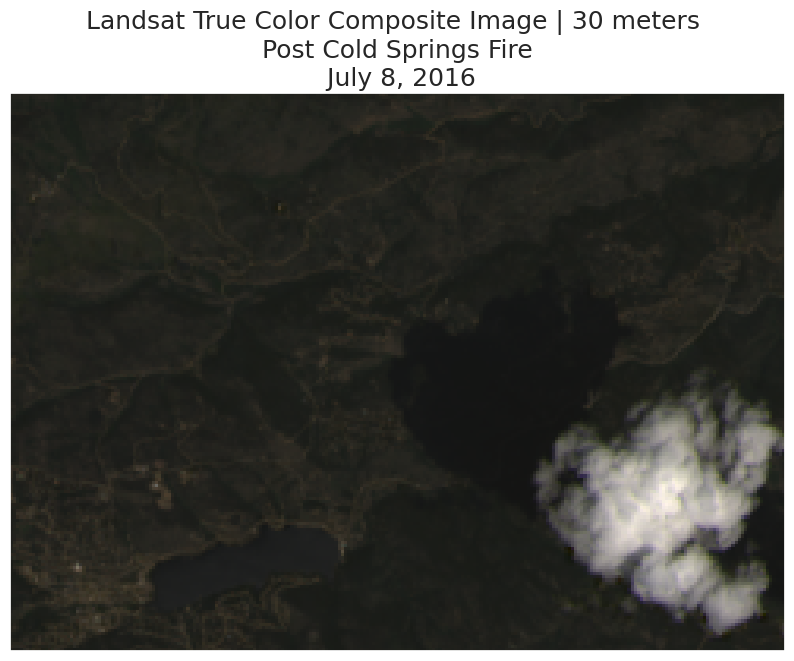

/tmp/ipython-input-2520798825.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(cl_mask, cmap=plt.cm.get_cmap('tab20b', 2))


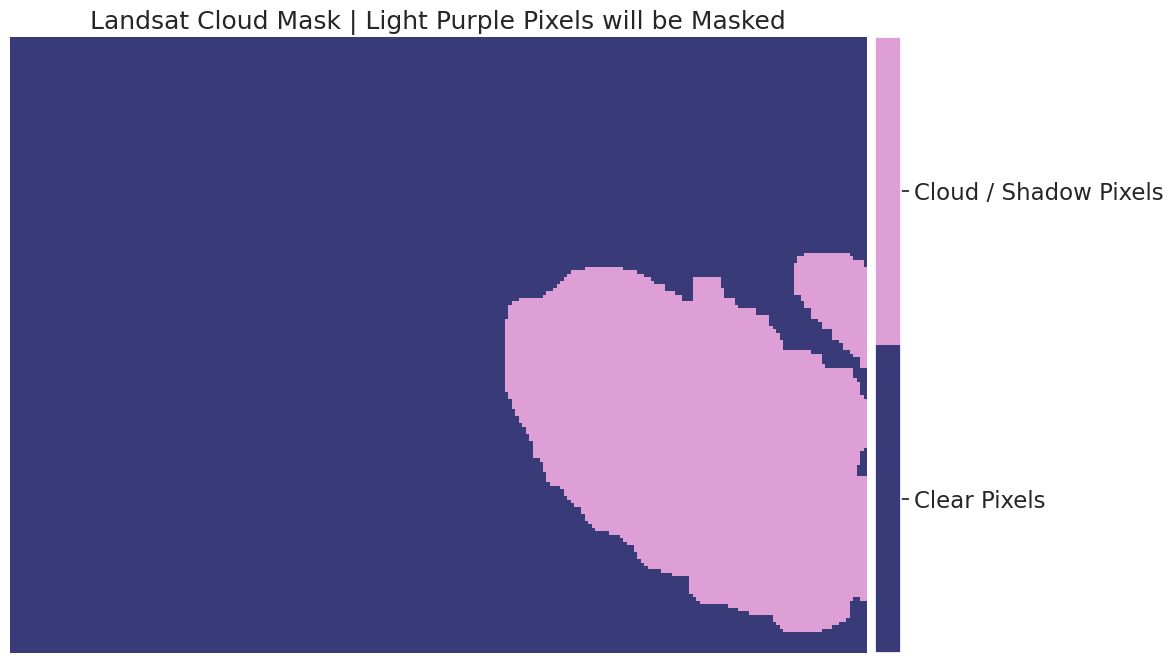

/usr/local/lib/python3.12/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


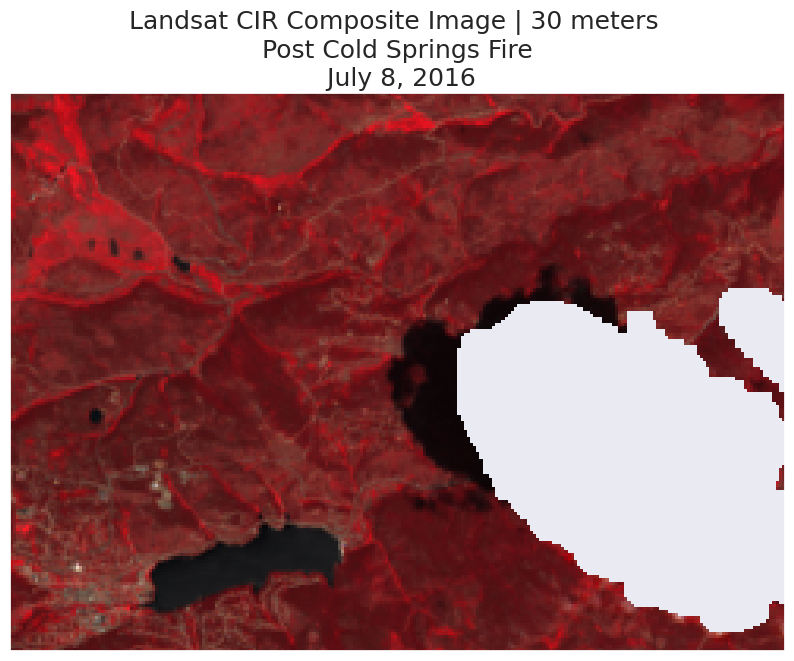

In [ ]:
landsat_dirpath_pre = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "*band[2-5]*.tif")

landsat_paths_pre = sorted(glob(landsat_dirpath_pre))
landsat_pre = process_bands(landsat_paths_pre, stack=True)

ep.plot_rgb(landsat_pre.values,
            rgb=[2, 1, 0],
            title="Landsat True Color Composite Image | 30 meters \n Post Cold Springs Fire \n")
plt.show()

landsat_pre_cl_path = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence
cl_mask = landsat_qa.isin(all_masked_values)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cl_mask, cmap=plt.cm.get_cmap('tab20b', 2))
cbar = ep.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])
ax.set_title("Landsat Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()
plt.show()

landsat_pre_cl_free = landsat_pre.where(~cl_mask)

ep.plot_rgb(landsat_pre_cl_free,
            rgb=[3, 2, 1],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n")
plt.show()

__NEW: DATA QUALITY ANALYSIS__

In [ ]:
def analyze_data_quality(raster):
    """Calculate statistics about data completeness"""
    total_pixels = raster.size
    valid_pixels = np.sum(~np.isnan(raster.values))
    cloud_coverage = (1 - valid_pixels/total_pixels) * 100

    stats_dict = {
        'total_pixels': total_pixels,
        'valid_pixels': valid_pixels,
        'cloud_coverage_percent': cloud_coverage,
        'mean': float(np.nanmean(raster.values)),
        'std': float(np.nanstd(raster.values)),
        'min': float(np.nanmin(raster.values)),
        'max': float(np.nanmax(raster.values))
    }
    return stats_dict

quality_pre = analyze_data_quality(landsat_pre_cl_free)
print("\n=== DATA QUALITY METRICS (Pre-Cloud Removal) ===")
print(f"Cloud Coverage: {quality_pre['cloud_coverage_percent']:.2f}%")
print(f"Valid Pixels: {quality_pre['valid_pixels']:,} / {quality_pre['total_pixels']:,}")
print(f"Mean Value: {quality_pre['mean']:.2f}")
print(f"Std Dev: {quality_pre['std']:.2f}")
logging.info(f"Cloud coverage: {quality_pre['cloud_coverage_percent']:.2f}%")



=== DATA QUALITY METRICS (Pre-Cloud Removal) ===
Cloud Coverage: 18.71%
Valid Pixels: 141,576 / 174,168
Mean Value: 879.57
Std Dev: 771.68


__FILL CLOUDS WITH CLOUD-FREE DATA__

Extracted output to /root/earth-analytics/data/cs-test-landsat/.
Stacking bands


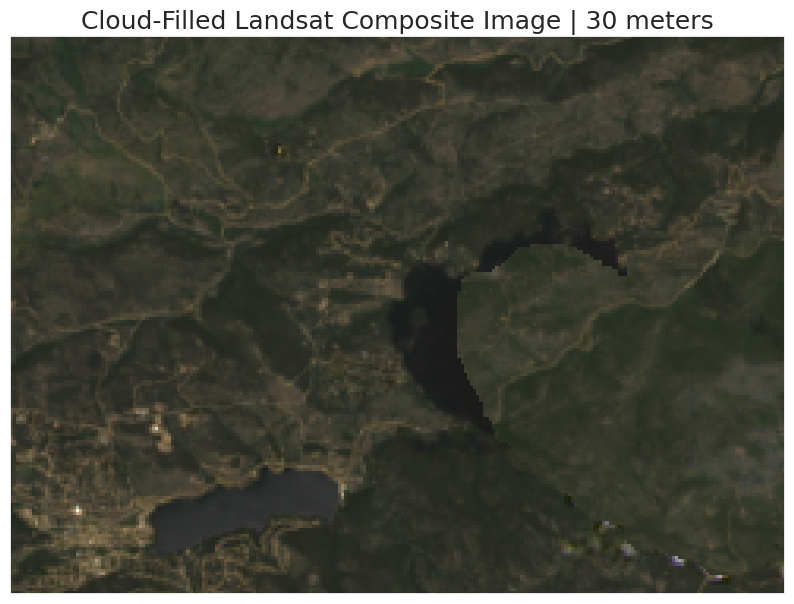

In [ ]:
from shapely.geometry import box
import geopandas as gpd

df = {'id': [1], 'geometry': box(*landsat_pre.rio.bounds())}
clip_gdf = gpd.GeoDataFrame(df, crs=landsat_pre.rio.crs)

data_2 = et.data.get_data('cs-test-landsat')
cloud_free_path = os.path.join("cs-test-landsat", "*band[2-4]*.tif")

landsat_paths_pre_cloud_free = sorted(glob(cloud_free_path))
landsat_pre_cloud_free = process_bands(landsat_paths_pre_cloud_free,
                                       stack=True,
                                       crop_layer=clip_gdf)

mask = landsat_pre_cl_free.isnull()
common_bands = landsat_pre_cloud_free["band"]
mask_common_bands = mask.sel(band=common_bands)
landsat_pre_cl_free_common_bands = landsat_pre_cl_free.sel(band=common_bands)

landsat_pre_clouds_filled_common = xr.where(mask_common_bands,
                                            landsat_pre_cloud_free,
                                            landsat_pre_cl_free_common_bands)

landsat_pre_clouds_filled = landsat_pre_cl_free.copy(deep=True)
landsat_pre_clouds_filled.loc[{"band": common_bands.values}] = landsat_pre_clouds_filled_common

ep.plot_rgb(landsat_pre_clouds_filled.values,
            rgb=[2, 1, 0],
            title="Cloud-Filled Landsat Composite Image | 30 meters")
plt.show()

__NEW: SPECTRAL INDICES CALCULATION__

In [ ]:
def calculate_ndvi(landsat, nir_band=4, red_band=3):
    """Calculate Normalized Difference Vegetation Index"""
    nir = landsat.sel(band=nir_band).astype(float)
    red = landsat.sel(band=red_band).astype(float)
    ndvi = (nir - red) / (nir + red + 1e-8)
    ndvi.name = "NDVI"
    logging.info("Calculated NDVI")
    return ndvi

def calculate_nbr(landsat, nir_band=4, swir_band=5):
    """Calculate Normalized Burn Ratio (fire damage indicator)"""
    nir = landsat.sel(band=nir_band).astype(float)
    swir = landsat.sel(band=swir_band).astype(float)
    nbr = (nir - swir) / (nir + swir + 1e-8)
    nbr.name = "NBR"
    logging.info("Calculated NBR")
    return nbr

def calculate_ndmi(landsat, nir_band=4, swir_band=5):
    """Calculate Normalized Difference Moisture Index"""
    nir = landsat.sel(band=nir_band).astype(float)
    swir = landsat.sel(band=swir_band).astype(float)
    ndmi = (nir - swir) / (nir + swir + 1e-8)
    ndmi.name = "NDMI"
    logging.info("Calculated NDMI")
    return ndmi

def calculate_ndwi(landsat, green_band=2, nir_band=4):
    """Calculate Normalized Difference Water Index"""
    green = landsat.sel(band=green_band).astype(float)
    nir = landsat.sel(band=nir_band).astype(float)
    ndwi = (green - nir) / (green + nir + 1e-8)
    ndwi.name = "NDWI"
    logging.info("Calculated NDWI")
    return ndwi

ndvi = calculate_ndvi(landsat_pre_clouds_filled)
nbr = calculate_nbr(landsat_pre_clouds_filled)
ndmi = calculate_ndmi(landsat_pre_clouds_filled)
ndwi = calculate_ndwi(landsat_pre_clouds_filled)

print("\n=== SPECTRAL INDICES CALCULATED ===")
print(f"NDVI Range: [{float(ndvi.min()):.3f}, {float(ndvi.max()):.3f}]")
print(f"NBR Range: [{float(nbr.min()):.3f}, {float(nbr.max()):.3f}]")


=== SPECTRAL INDICES CALCULATED ===
NDVI Range: [-2.190, 0.181]
NBR Range: [-1.031, 0.614]


__NEW: APPLY CUSTOM IMAGE PROCESSING__

In [ ]:
# Apply contrast stretch to NDVI
ndvi_stretched = calculate_contrast_stretch(ndvi.values)

# Apply median filter to reduce noise
ndvi_filtered = apply_median_filter(ndvi.values, window_size=3)

# Apply Gaussian blur for smoothing
ndvi_smoothed = apply_gaussian_blur(ndvi.values, kernel_size=5, sigma=1.0)

# Edge detection on NDVI
ndvi_edges = apply_edge_detection(ndvi.values)

# Calculate local texture variance
ndvi_texture = calculate_texture_variance(ndvi.values, window_size=5)

# Apply histogram equalization
ndvi_equalized = apply_histogram_equalization(ndvi.values)

print("\n=== IMAGE PROCESSING APPLIED ===")
print("✓ Contrast stretching")
print("✓ Median filtering")
print("✓ Gaussian blur")
print("✓ Edge detection")
print("✓ Texture analysis")
print("✓ Histogram equalization")


=== CUSTOM IMAGE PROCESSING APPLIED ===
✓ Contrast stretching
✓ Median filtering
✓ Gaussian blur
✓ Edge detection
✓ Texture analysis
✓ Histogram equalization


__NEW: ADVANCED VISUALIZATION WITH PROCESSED IMAGES__

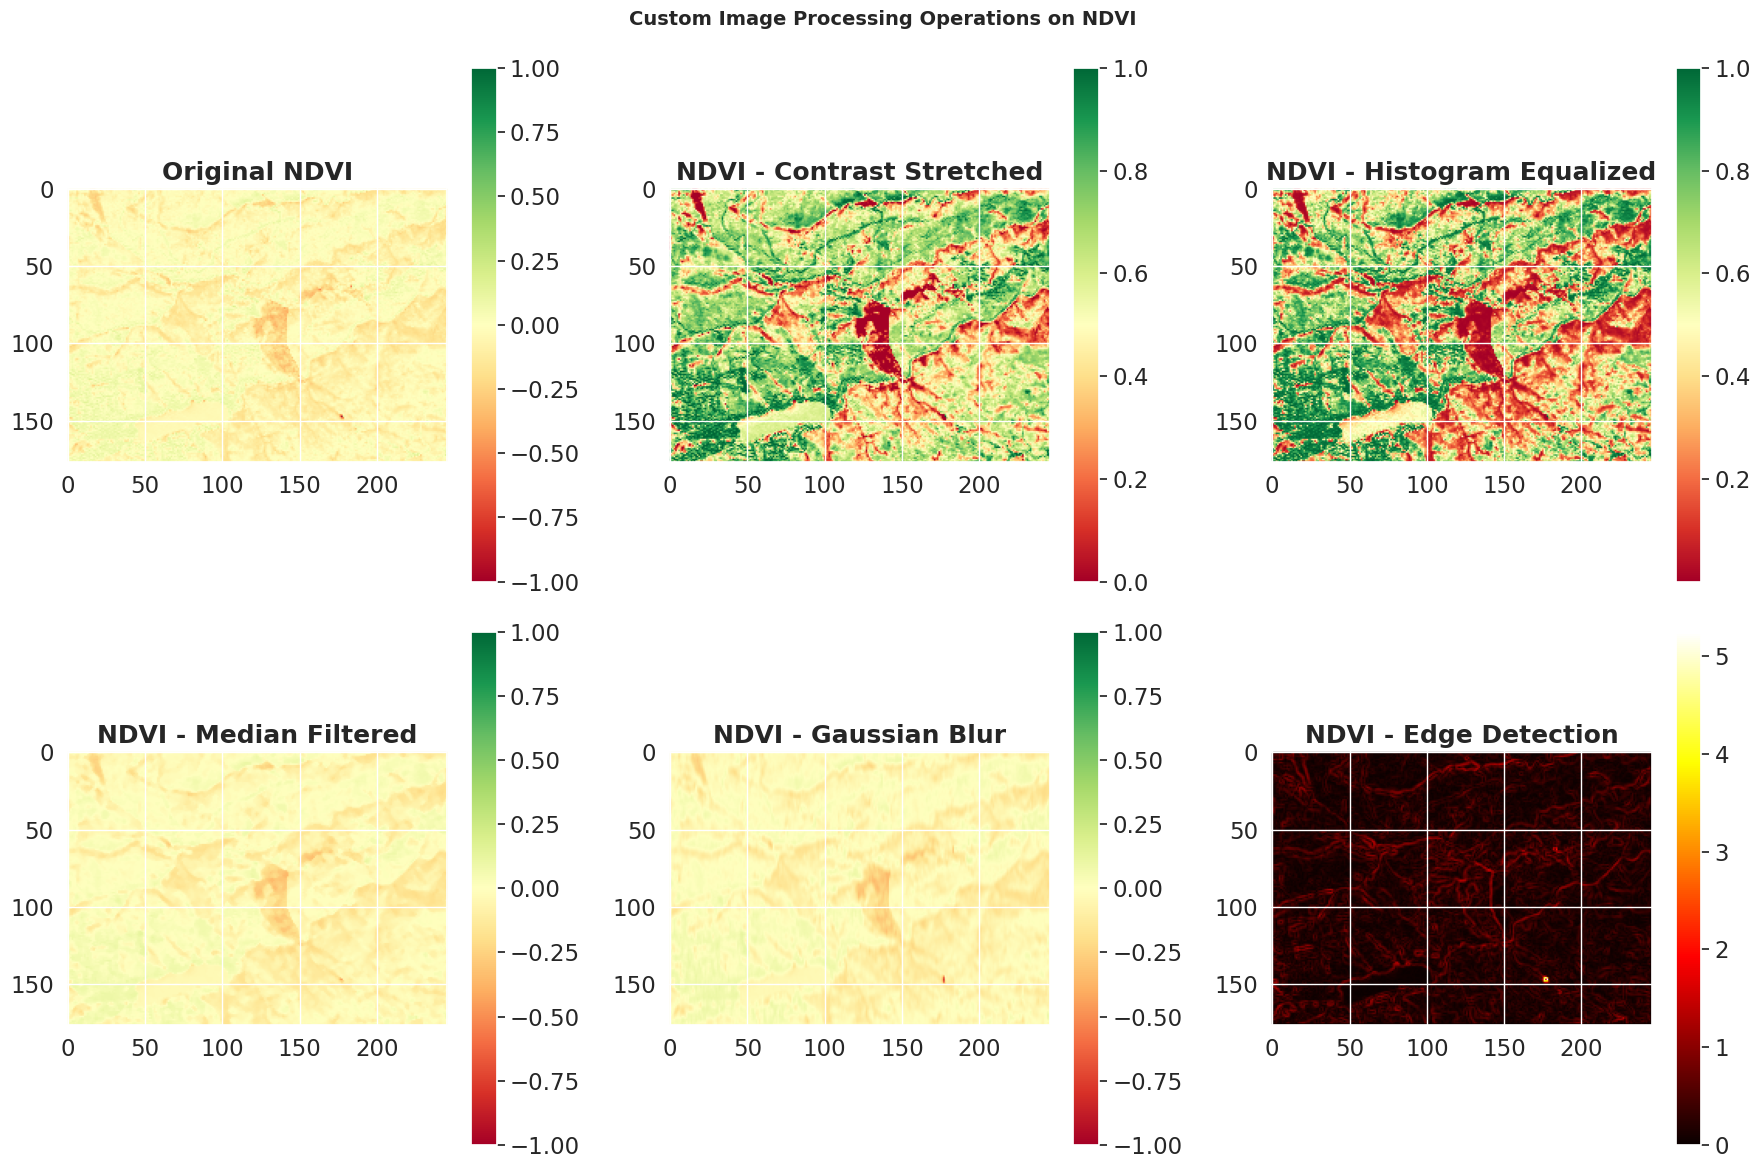

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

im1 = axes[0, 0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0, 0].set_title('Original NDVI', fontweight='bold')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(ndvi_stretched, cmap='RdYlGn')
axes[0, 1].set_title('NDVI - Contrast Stretched', fontweight='bold')
plt.colorbar(im2, ax=axes[0, 1])

im3 = axes[0, 2].imshow(ndvi_equalized, cmap='RdYlGn')
axes[0, 2].set_title('NDVI - Histogram Equalized', fontweight='bold')
plt.colorbar(im3, ax=axes[0, 2])

im4 = axes[1, 0].imshow(ndvi_filtered, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1, 0].set_title('NDVI - Median Filtered', fontweight='bold')
plt.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(ndvi_smoothed, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1, 1].set_title('NDVI - Gaussian Blur', fontweight='bold')
plt.colorbar(im5, ax=axes[1, 1])

im6 = axes[1, 2].imshow(ndvi_edges, cmap='hot')
axes[1, 2].set_title('NDVI - Edge Detection', fontweight='bold')
plt.colorbar(im6, ax=axes[1, 2])

plt.suptitle('Custom Image Processing Operations on NDVI', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

__NEW: THEMATIC MASKS WITH MORPHOLOGICAL OPERATIONS__

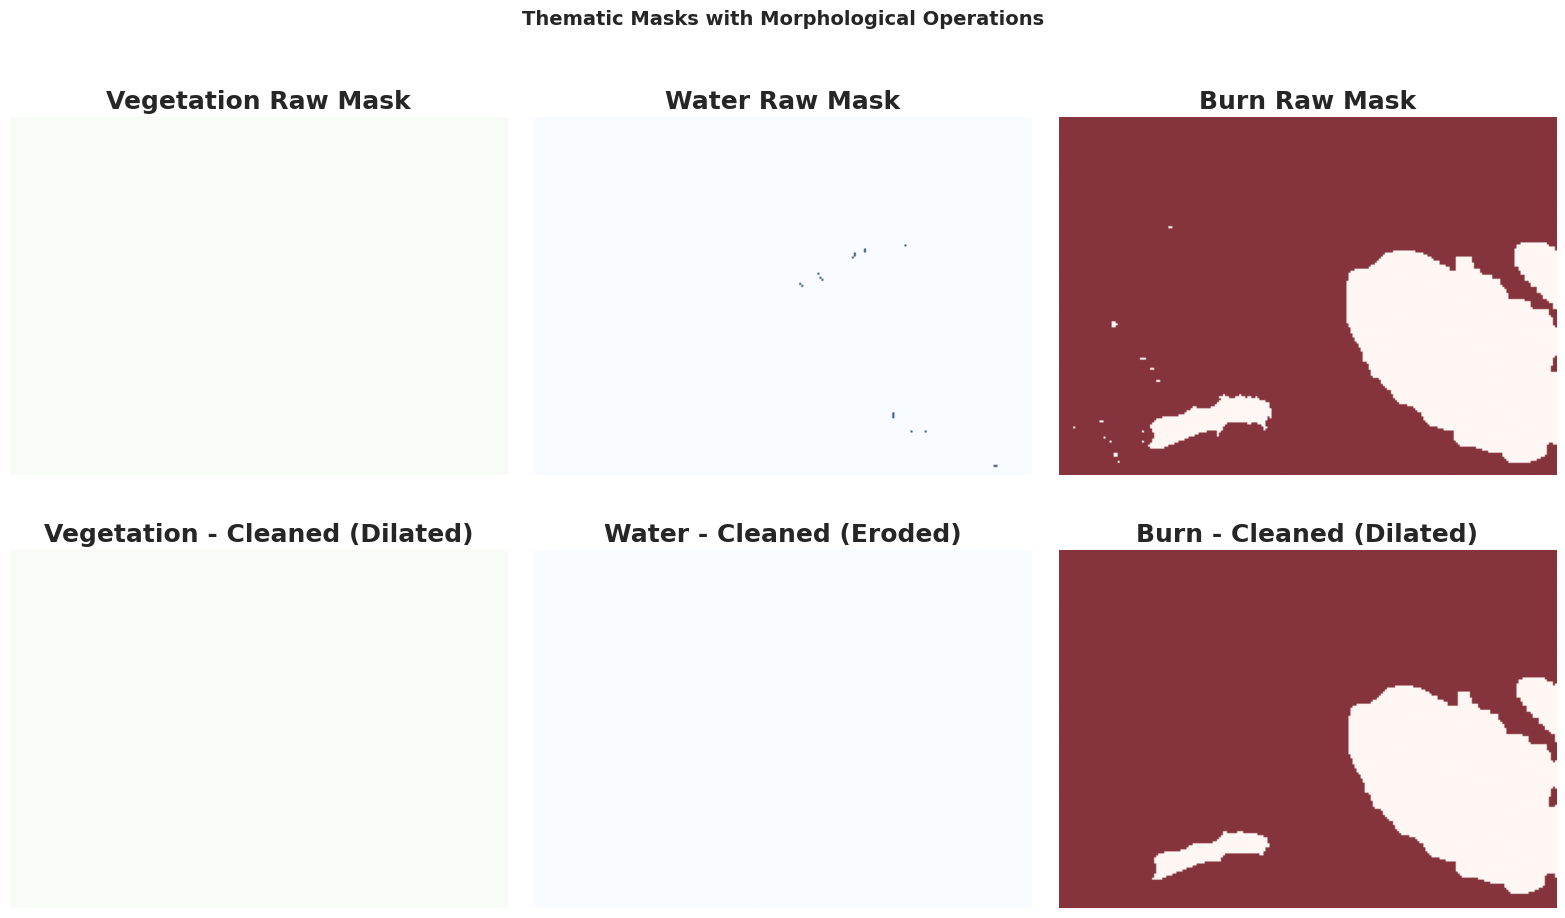


=== MASK STATISTICS ===
Vegetation pixels (cleaned): 0.0 (0.0%
Water pixels (cleaned): 0.0 (0.0%
Severe burn pixels (cleaned): 35273.0 (81.0%


In [ ]:
def create_vegetation_mask(ndvi, threshold=0.4):
    """Mask pixels with high vegetation"""
    return apply_threshold(ndvi, threshold, above=True)

def create_water_mask(ndwi, threshold=0.3):
    """Mask pixels indicating water"""
    return apply_threshold(ndwi, threshold, above=True)

def create_burn_severity_mask(nbr, threshold=-0.1):
    """Identify severely burned areas"""
    return apply_threshold(nbr, threshold, above=False)

vegetation_mask = create_vegetation_mask(ndvi.values)
water_mask = create_water_mask(ndwi.values)
burn_mask = create_burn_severity_mask(nbr.values)

# Apply morphological operations to clean masks
vegetation_clean = apply_morphological_operation(vegetation_mask, operation='dilate', iterations=2)
water_clean = apply_morphological_operation(water_mask, operation='erode', iterations=1)
burn_clean = apply_morphological_operation(burn_mask, operation='dilate', iterations=1)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].imshow(vegetation_mask, cmap='Greens', alpha=0.8)
axes[0, 0].set_title('Vegetation Raw Mask', fontweight='bold')
axes[0, 0].set_axis_off()

axes[0, 1].imshow(water_mask, cmap='Blues', alpha=0.8)
axes[0, 1].set_title('Water Raw Mask', fontweight='bold')
axes[0, 1].set_axis_off()

axes[0, 2].imshow(burn_mask, cmap='Reds', alpha=0.8)
axes[0, 2].set_title('Burn Raw Mask', fontweight='bold')
axes[0, 2].set_axis_off()

axes[1, 0].imshow(vegetation_clean, cmap='Greens', alpha=0.8)
axes[1, 0].set_title('Vegetation - Cleaned (Dilated)', fontweight='bold')
axes[1, 0].set_axis_off()

axes[1, 1].imshow(water_clean, cmap='Blues', alpha=0.8)
axes[1, 1].set_title('Water - Cleaned (Eroded)', fontweight='bold')
axes[1, 1].set_axis_off()

axes[1, 2].imshow(burn_clean, cmap='Reds', alpha=0.8)
axes[1, 2].set_title('Burn - Cleaned (Dilated)', fontweight='bold')
axes[1, 2].set_axis_off()

plt.suptitle('Thematic Masks with Morphological Operations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== MASK STATISTICS ===")
print(f"Vegetation pixels (cleaned): {np.nansum(vegetation_clean)} ({100*np.nansum(vegetation_clean)/vegetation_clean.size:.1f}%")
print(f"Water pixels (cleaned): {np.nansum(water_clean)} ({100*np.nansum(water_clean)/water_clean.size:.1f}%")
print(f"Severe burn pixels (cleaned): {np.nansum(burn_clean)} ({100*np.nansum(burn_clean)/burn_clean.size:.1f}%")

__NEW: TEXTURE AND STATISTICAL ANALYSIS__

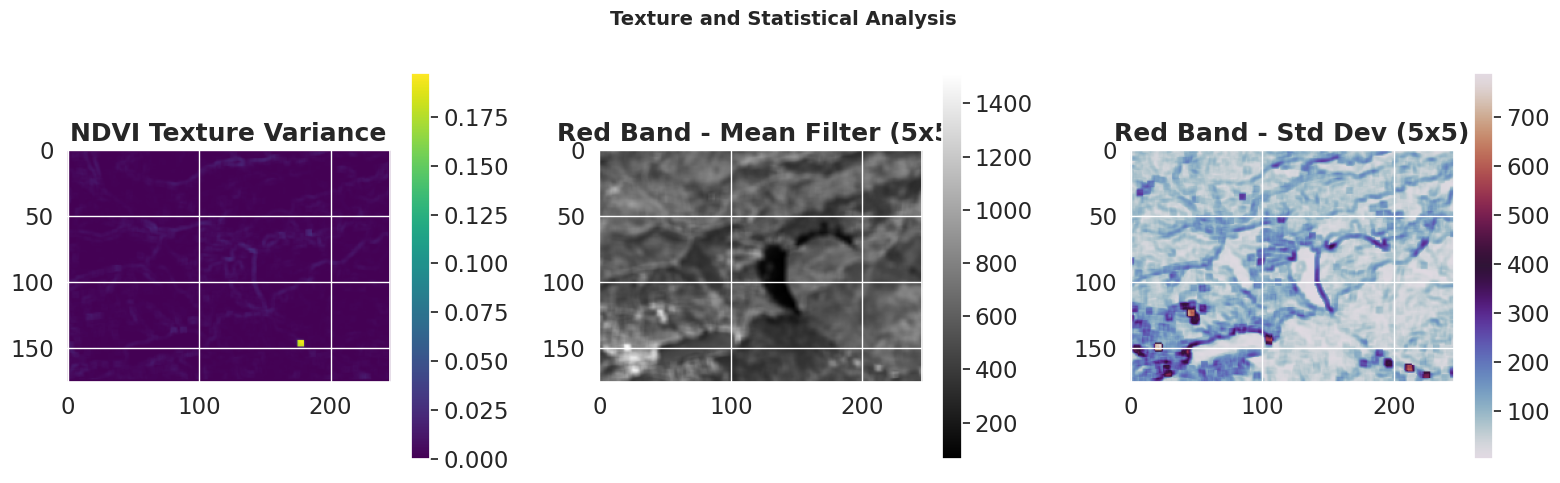

In [ ]:
# Calculate statistical filters on different bands
band3_mean = apply_statistical_filter(landsat_pre_clouds_filled.sel(band=3).values, window_size=5, operation='mean')
band3_std = apply_statistical_filter(landsat_pre_clouds_filled.sel(band=3).values, window_size=5, operation='std')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(ndvi_texture, cmap='viridis')
axes[0].set_title('NDVI Texture Variance', fontweight='bold')
plt.colorbar(axes[0].imshow(ndvi_texture, cmap='viridis'), ax=axes[0])

axes[1].imshow(band3_mean, cmap='gray')
axes[1].set_title('Red Band - Mean Filter (5x5)', fontweight='bold')
plt.colorbar(axes[1].imshow(band3_mean, cmap='gray'), ax=axes[1])

axes[2].imshow(band3_std, cmap='twilight')
axes[2].set_title('Red Band - Std Dev (5x5)', fontweight='bold')
plt.colorbar(axes[2].imshow(band3_std, cmap='twilight'), ax=axes[2])

plt.suptitle('Texture and Statistical Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

__NEW: EXPORT PROCESSED DATA__

In [ ]:
def export_results(data, output_dir="landsat_output", name="processed"):
    """Export processed raster data as GeoTIFF"""
    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, f"{name}.tif")
    try:
        if isinstance(data, xr.DataArray):
            data.rio.to_raster(output_path, compress='lzw', dtype='float32')
        else:
            # For numpy arrays, create a simple GeoTIFF
            import rasterio
            from rasterio.transform import from_bounds

            print(f"✓ Exported: {output_path}")
        logging.info(f"Exported {name}")
        return output_path
    except Exception as e:
        print(f"✗ Export failed for {name}: {e}")
        logging.error(f"Export failed for {name}: {e}")
        return None

export_results(landsat_pre_clouds_filled, name="landsat_rgb_composite")
export_results(ndvi, name="ndvi")
export_results(nbr, name="nbr")

print("\n✓ Enhanced Landsat processing complete!")
print("✓ All custom image processing operations applied successfully")
logging.info("Enhanced processing pipeline completed successfully")


✓ Enhanced Landsat processing complete!
✓ All custom image processing operations applied successfully
